# Chirp synchronization

June 21, 2018

In [259]:
%matplotlib inline

from numpy import array, zeros, append, linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt, log10, var
from scipy.io.wavfile import write
from scipy.signal import spectrogram
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas

In [260]:
SAMPLING_RATE = 100000  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F1 = 17000
F2 = 18000

## Chirp tone synthesis

In [261]:
# Complex version of chirp tone generator
def chirp(f1=F1, f2=F2, amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return exp(1j * arg) * amp

# Real version of chirp tone generator
def chirp_cos(f1=F1, f2=F2, amp=AMPLITUDE, updown="up", length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    delta = float(f2 - f1)/float(length)
    if (updown == "up"):
        freq = f1 + delta * t
    elif (updown == "down"):
        freq = f2 - delta * t
    arg = (2 * pi * freq * t) * rot + phase
    return cos(arg) * amp

# Add time delay to chirp signal
def add_delay(chirp, delay_rate=0.0):
    l = len(chirp)
    la = int(l * delay_rate)
    a = zeros(la)
    b = zeros(2 * l - (l + la))
    return append(append(a, chirp), b)

# Time shift to chirp signal
def time_shift(chirp, shift_rate=0.0):
    l = len(chirp)
    t = int(l * shift_rate)
    return append(chirp[t:], chirp[:t])

# White noise generator
def white_noise(amp=AMPLITUDE, length=TIME_FRAME):
    a = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    # b = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    #return a + 1j * b
    return a

# Constant noise generator
def constant_noise(freq=0, amp=AMPLITUDE, length=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(length * SAMPLING_RATE))
    arg = (2 * pi * freq * t) * rot + phase
    return cos(arg) * amp


## FFT/IFFT functions

In [262]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.99, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

# Peaks
def fft_peaks(wave, thres=0.99, logscale=False):
    y = fftshift(fft(wave))

    a = abs(y)
    center = int(SAMPLES/2)
    a[center-300:center+300] = 0

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    return(freq[peakutils.indexes(a, thres=thres)])

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")

## Wave display

In [263]:
# Plot wave
def plot_wave(wave, real_only=True, logscale=False):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)

    re = real(wave)
    im = imag(wave)
    if logscale:
        re = 10 * log10(re)
        im = 10 * log10(im)
        plt.ylabel('Amplitude(dB)')
    else:
        plt.ylabel('Amplitude')

    if real_only:
        plt.plot(t, re)
    else:
        plt.plot(t, re)
        plt.plot(t, im)

    plt.xlabel('Time [sec]')
    plt.title("Time domain")

# Support function

In [264]:
def plot_correlation(shift_rate=0.0):
    down_chirp = chirp(length=TIME_FRAME, updown="down")
    wave = time_shift(chirp_cos(length=TIME_FRAME), shift_rate) * down_chirp
    plot_fft(wave)
    print("F1 + F2 = {} Hz".format(F1+F2))
    print("Peaks: {} Hz".format(fft_peaks(wave, thres=0.3)))

def peaks(shift_rate=0.0, thres=0.3):
    down_chirp = chirp(length=TIME_FRAME, updown="down")
    wave = time_shift(chirp_cos(length=TIME_FRAME), shift_rate) * down_chirp
    return(fft_peaks(wave, thres=thres))

## 0% shift

F1 + F2 = 35000 Hz
Peaks: [35009.765625] Hz


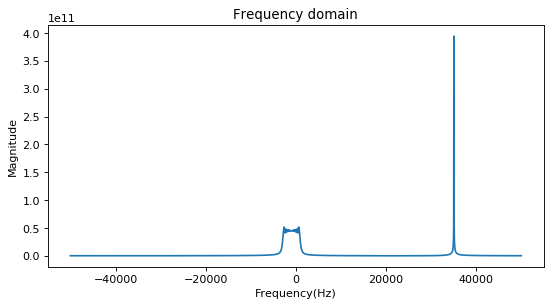

In [265]:
plot_correlation(0.0)

## 25% shift

F1 + F2 = 35000 Hz
Peaks: [33496.09375  35498.046875] Hz


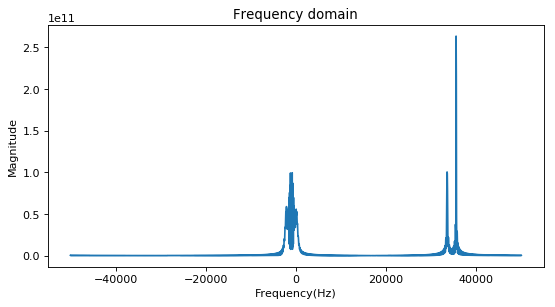

In [266]:
plot_correlation(0.25)

## 50% shift

F1 + F2 = 35000 Hz
Peaks: [34033.203125 36035.15625 ] Hz


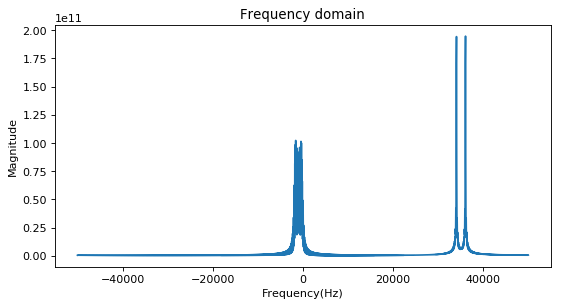

In [267]:
plot_correlation(0.5)

## 75% shift

F1 + F2 = 35000 Hz
Peaks: [34521.484375 36523.4375  ] Hz


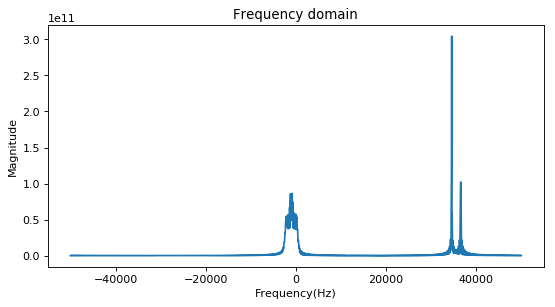

In [268]:
plot_correlation(0.75)

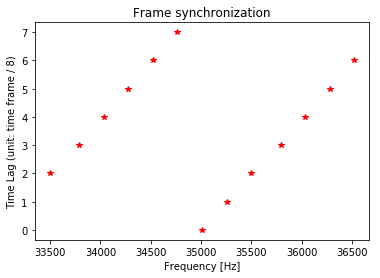

In [281]:
shift = [i/100*100/8 for i in range(8)]
position = [i for i in range(8)]
p1 = []
p2 = []
for rate in shift:
    p = sorted(peaks(rate, thres=0.3))
    p1.append(p[-1])
    if len(p) < 2:
        p2.append(None)
    else:
        p2.append(p[-2])
plt.title('Frame synchronization')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Time Lag (unit: time frame / 8)')
plt.plot(p1, position, "r*")
plt.plot(p2, position, "r*")